In [127]:
import os
import sys
sys.path.append("/home/rohit/PhD_Work/GM_my_version/Graph_matching/")
from sklearn.cluster import KMeans
import networkx as nx
import numpy as np
from graph_generation.load_graphs_and_create_metadata import dataset_metadata
from graph_matching_tools.metrics import matching
import matplotlib.pyplot as plt
import scipy.io as sco
import slam.io as sio
from scipy.special import softmax
import pickle
from scipy.stats import betabinom
import seaborn as sns
import tools.graph_processing as gp
import tools.graph_visu as gv
from matplotlib.pyplot import figure
import pickle
import pandas as pd
from torch_geometric.utils.convert import from_networkx
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.nn.functional import one_hot
from sklearn.preprocessing import OneHotEncoder
from torch.nn import Linear
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import TopKPooling
from torch_geometric.data import Data
%matplotlib inline

In [73]:
path_to_labelled_graphs = '/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/Oasis_original_new_with_dummy/labelled_graphs/'

In [74]:
correspondence = pickle.load( open( "graph_correspondence_new.pickle", "rb" ) )

In [75]:
Oasis_phen = pd.read_excel("/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/OASIS_phenotype.ods", engine="odf")

In [76]:
# Correspondence between sulcal graphs(OASIS) and gender. 

#Oasis_phen[['Subject','M/F']]
oasis_ids = Oasis_phen['Subject'].to_list()
gender = Oasis_phen['M/F'].to_list()

gender_corresp = []

for corr in correspondence:
    corr_id = corr[0].split('_lh')
    
    for o_id, gen in zip(oasis_ids, gender):
        if o_id == corr_id[0]:
            gender_corresp.append([o_id,corr[1],gen])

In [77]:
gender_corresp[:6]

[['OAS1_0410', 'graph_00000.gpickle', 'F'],
 ['OAS1_0250', 'graph_00001.gpickle', 'M'],
 ['OAS1_0153', 'graph_00002.gpickle', 'M'],
 ['OAS1_0246', 'graph_00003.gpickle', 'F'],
 ['OAS1_0151', 'graph_00004.gpickle', 'F'],
 ['OAS1_0321', 'graph_00005.gpickle', 'M']]

In [7]:
correspondence[64]

('OAS1_0061_lh_pitgraph.gpickle', 'graph_00064.gpickle')

In [8]:
#pickle.dump(gender_corresp, open( "gender_correspondence.pickle", "wb" ))

## GNN on sulcal graphs

In [9]:
def graph_remove_dummy_nodes(graph):
    nodes_dummy_true = [x for x,y in graph.nodes(data=True) if y['is_dummy']==True]
    graph.remove_nodes_from(nodes_dummy_true)
    #print(len(graph.nodes))

In [10]:
# Create graph level labels (here gender)
onehot = OneHotEncoder(drop='first')
graph_labels = onehot.fit_transform(np.array(gender_corresp)[:,2].reshape(-1,1)).toarray()

In [11]:
# Convert networkx graphs to pyg graphs

list_graphs = gp.load_graphs_in_list(path_to_labelled_graphs)

sulcal_dataset = []

for i,g in enumerate(list_graphs):
    graph_remove_dummy_nodes(g) # remove dummy nodes
    g.remove_edges_from(nx.selfloop_edges(g)) # remove self loop edges
    
    attr_coords = np.array(list(nx.get_node_attributes(g,'sphere_3dcoords').values()))
    attr_basin_area = np.array(list(nx.get_node_attributes(g,'basin_area').values())).reshape([len(g),1])
    attr_basin_thickness = np.array(list(nx.get_node_attributes(g,'basin_thickness').values())).reshape([len(g),1])
    attr_depth = np.array(list(nx.get_node_attributes(g,'depth').values())).reshape([len(g),1])
    
    attr_concat = np.concatenate((attr_coords,attr_basin_area,attr_basin_thickness,attr_depth),axis = 1)
    
    x = torch.tensor(attr_concat,dtype=torch.float)
    
    #x = torch.tensor(nx.adjacency_matrix(g).todense(),dtype=torch.float)
    y = torch.tensor(graph_labels[i],dtype=torch.long)
    edge_index = torch.tensor(list(g.edges))
    
    sulcal_dataset.append(Data(x=x, y=y, edge_index=edge_index.t().contiguous()))
    
    #sulcal_dataset.append(from_networkx(g))

In [12]:
list_graphs[22].nodes.data()[0]

{'vertex_index': 2812,
 'sphere_3dcoords': array([  3.09570885, -94.31793976, -33.08386612]),
 'sphere_coords': [-1.5379860401153564, 1.9079885482788086],
 'basin_label': 305.0,
 'basin_area': 664.00385,
 'depth': -0.45560634,
 'basin_thickness': 2.7713241577148438,
 'ico100_7_vertex_index': 1895,
 'label_neuroimage': 28,
 'label_media': 26,
 'sphere_3dcoords_noreg': array([ 18.87467 , -89.361855, -40.721077], dtype=float32),
 'ico100_7_vertex_index_noreg': 15264,
 'is_dummy': False,
 'label_color': 1.0,
 'labelling_mALS': 0.9426228724927491,
 'labelling_kerGM': 0.9426228724927491,
 'labelling_mSync': 0.9426228724927491}

In [13]:
sizes = [nx.number_of_nodes(g) for g in list_graphs]

In [14]:
sizes[56]

77

In [15]:
train_dataset = sulcal_dataset[:120]
test_dataset = sulcal_dataset[120:]

In [16]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [17]:
num_node_features = train_dataset[0].num_features
num_node_features

6

In [18]:
# Create GAT Model

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):        
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.in_head = 2
        self.out_head = 1
        
        self.emb_dim = 8
        
        
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=self.in_head)
        self.conv2 = GATConv(hidden_channels*self.in_head, hidden_channels,concat=False)
        self.conv3 = GATConv(hidden_channels, self.emb_dim, concat=False, dropout=0.6)
        self.lin = Linear(self.emb_dim, 2)
        

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        emb,attn_weights = self.conv3(x, edge_index,return_attention_weights=True)

        # 2. Readout layer
        g_emb = global_mean_pool(emb, batch)  # [batch_size, hidden_channels] TopKPooling
        #g_emb = TopKPooling(emb, batch)

        # 3. Apply a final classifier
        out = F.dropout(g_emb, p=0.5, training=self.training)
        out = self.lin(out)
        
        return out, g_emb, emb, attn_weights

model = GAT(hidden_channels=32)
print(model)

GAT(
  (conv1): GATConv(6, 32, heads=2)
  (conv2): GATConv(64, 32, heads=1)
  (conv3): GATConv(32, 8, heads=1)
  (lin): Linear(in_features=8, out_features=2, bias=True)
)


In [19]:
# # Create GNN Model

# class GCN(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super(GCN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GCNConv(num_node_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         self.conv3 = GCNConv(hidden_channels, hidden_channels)
#         self.lin = Linear(hidden_channels, 2)

#     def forward(self, x, edge_index, batch):
#         # 1. Obtain node embeddings 
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         emb = self.conv3(x, edge_index)

#         # 2. Readout layer
#         x = global_mean_pool(emb, batch)  # [batch_size, hidden_channels]

#         # 3. Apply a final classifier
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.lin(x)
        
#         return x,emb

# model = GCN(hidden_channels=32)
# print(model)

In [20]:
#model = GCN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    
    for data in train_loader:# Iterate in batches over the training dataset.
        out,g_emb,n_emb,_ = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out,g_emb,emb,_ = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [21]:
for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5000, Test Acc: 0.5294
Epoch: 002, Train Acc: 0.5167, Test Acc: 0.4706
Epoch: 003, Train Acc: 0.5083, Test Acc: 0.5294
Epoch: 004, Train Acc: 0.5083, Test Acc: 0.5294
Epoch: 005, Train Acc: 0.5833, Test Acc: 0.5882
Epoch: 006, Train Acc: 0.5583, Test Acc: 0.4706
Epoch: 007, Train Acc: 0.5083, Test Acc: 0.5882
Epoch: 008, Train Acc: 0.5500, Test Acc: 0.4118
Epoch: 009, Train Acc: 0.5667, Test Acc: 0.4118
Epoch: 010, Train Acc: 0.5667, Test Acc: 0.4118
Epoch: 011, Train Acc: 0.5500, Test Acc: 0.6471
Epoch: 012, Train Acc: 0.5250, Test Acc: 0.5882
Epoch: 013, Train Acc: 0.5833, Test Acc: 0.4706
Epoch: 014, Train Acc: 0.6167, Test Acc: 0.5882
Epoch: 015, Train Acc: 0.5833, Test Acc: 0.5882
Epoch: 016, Train Acc: 0.6417, Test Acc: 0.6471
Epoch: 017, Train Acc: 0.7000, Test Acc: 0.4118
Epoch: 018, Train Acc: 0.5917, Test Acc: 0.5294
Epoch: 019, Train Acc: 0.6583, Test Acc: 0.5294
Epoch: 020, Train Acc: 0.7083, Test Acc: 0.5294
Epoch: 021, Train Acc: 0.5500, Test Acc:

In [22]:
real_emb = []
  
all_graph = DataLoader(sulcal_dataset, batch_size=137, shuffle=False)

for data in all_graph:
    prob,g_emb,out_emb,attn_weights = model(data.x, data.edge_index, data.batch)
    
out_emb = out_emb.detach().numpy()
g_emb = g_emb.detach().numpy()


In [23]:
data.edge_index[0]

tensor([    0,     0,     0,  ..., 12089, 12090, 12091])

In [24]:
len_edges = len(data.edge_index[0])
attn_matrix = np.zeros([len_edges,len_edges])

counter = 0
for a,b in zip(data.edge_index[0],data.edge_index[1]):
    
    attn_matrix[int(a),int(b)] = float(attn_weights[1][counter])  # float(np.mean(attn_weights[1][counter].detach().numpy()))  # mean for multi-head attention 
    
    counter += 1  

In [25]:
# Extract attn_weights for each graph

init_count = 0
attn_mat_all=[]

for g in list_graphs:
    
    nb_nodes = len(g) + init_count
    #print('len(g), init_count : ', len(g), init_count)
    
    mat = attn_matrix[init_count:nb_nodes, init_count:nb_nodes]
    attn_mat_all.append(mat)
    #print(range(init_count,nb_nodes, len(g)))
    
    init_count+=len(g)

<AxesSubplot:>

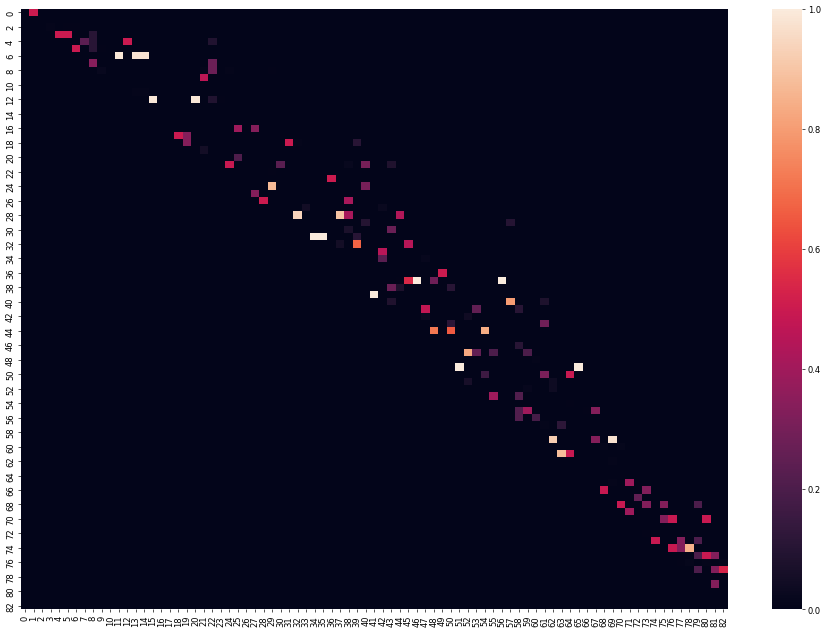

In [26]:
figure(figsize=(19, 13), dpi=60)
sns.heatmap(attn_mat_all[1])

In [229]:
#pickle.dump(attn_mat_all, open( "attn_mat_list_layer_3.pickle", "wb" ))

In [28]:
# figure(figsize=(6, 6), dpi=80)
# plt.imshow(np.random.random((50,50)))
# plt.colorbar()
# plt.show()

# tsne on node emb

In [29]:
# gender label for each graph

pit_labels = []
for i,g in enumerate(list_graphs):
    size_g = nx.number_of_nodes(g)
    pit_labels.extend(list(graph_labels[i]) * size_g)

In [30]:
from sklearn.manifold import TSNE
import pandas as pd

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(out_emb)
tsne_result.shape

(12094, 2)

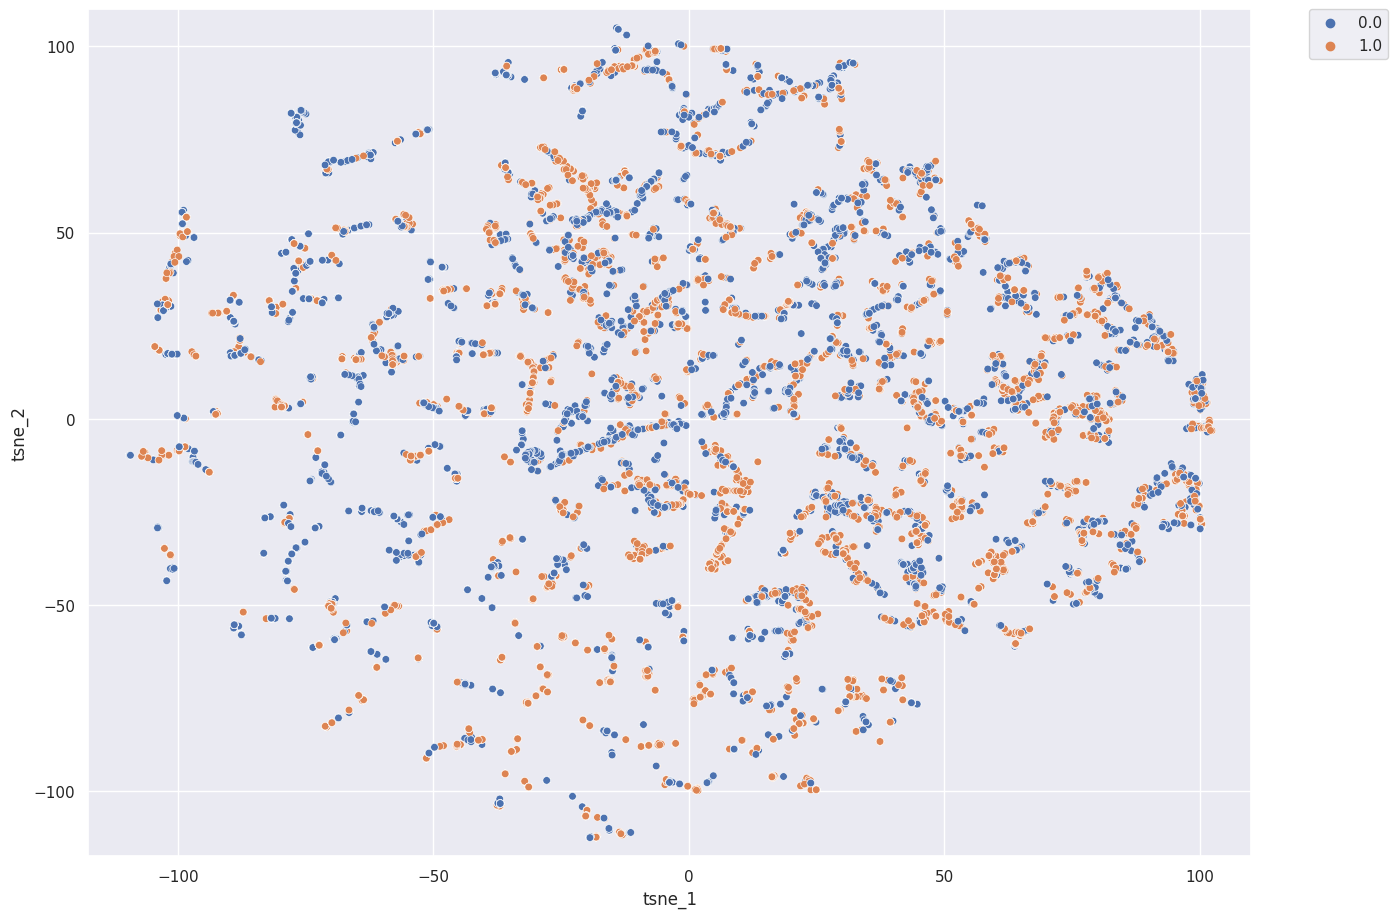

In [31]:
sns.set(rc={'figure.figsize':(15,11)})
#sns.set(rc={'axes.facecolor':'#DCE8F4'})

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': pit_labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=30)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
#ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


## Kmeans labels on node embeddings 

In [172]:
def get_all_coords(list_graphs):
    all_coords = []
    for g in list_graphs:
        coords = np.array(list(nx.get_node_attributes(g,'sphere_3dcoords').values()))
        all_coords.extend(coords)
    all_coords = np.array(all_coords)
    
    return all_coords

In [181]:
def get_labels_from_k_means(k, coords):
    
    kmeans = KMeans(n_init= 'auto',n_clusters=k, random_state=0).fit(coords)
    
    return kmeans.labels_

In [182]:
# Visualize obtained matching labels from kmeans on node embeddings 
k = 90
all_coords = get_all_coords(list_graphs)         
kmeans_labels = get_labels_from_k_means(k, all_coords)

<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

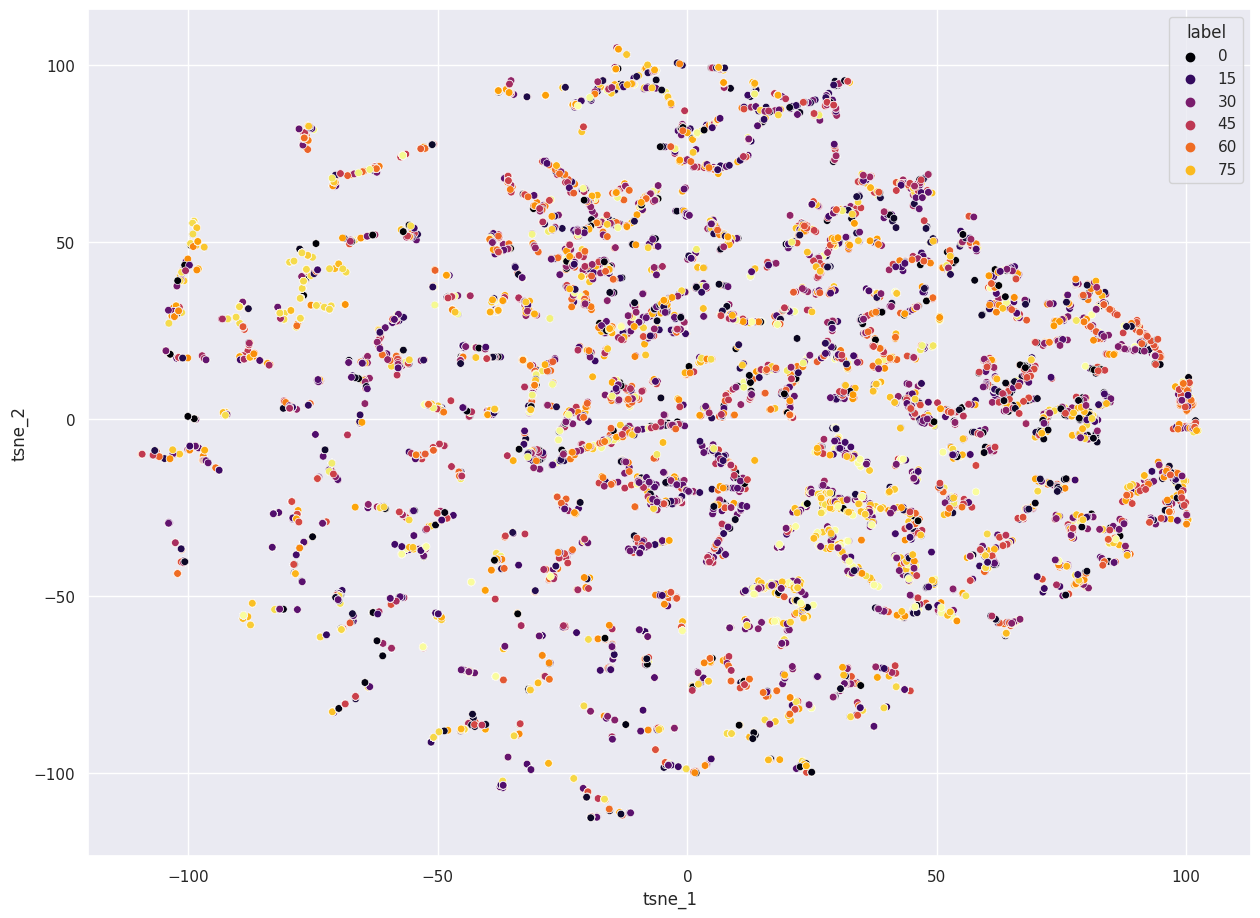

In [202]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': kmeans_labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=30,palette='inferno')

In [ ]:
# Kmeans on embeddings 
k1 = 90
kmeans_labels_emb = get_labels_from_k_means(k1, out_emb)

In [230]:
#pickle.dump(kmeans_labels_emb, open( "kmeans_labels_emb.pickle", "wb" ))

<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

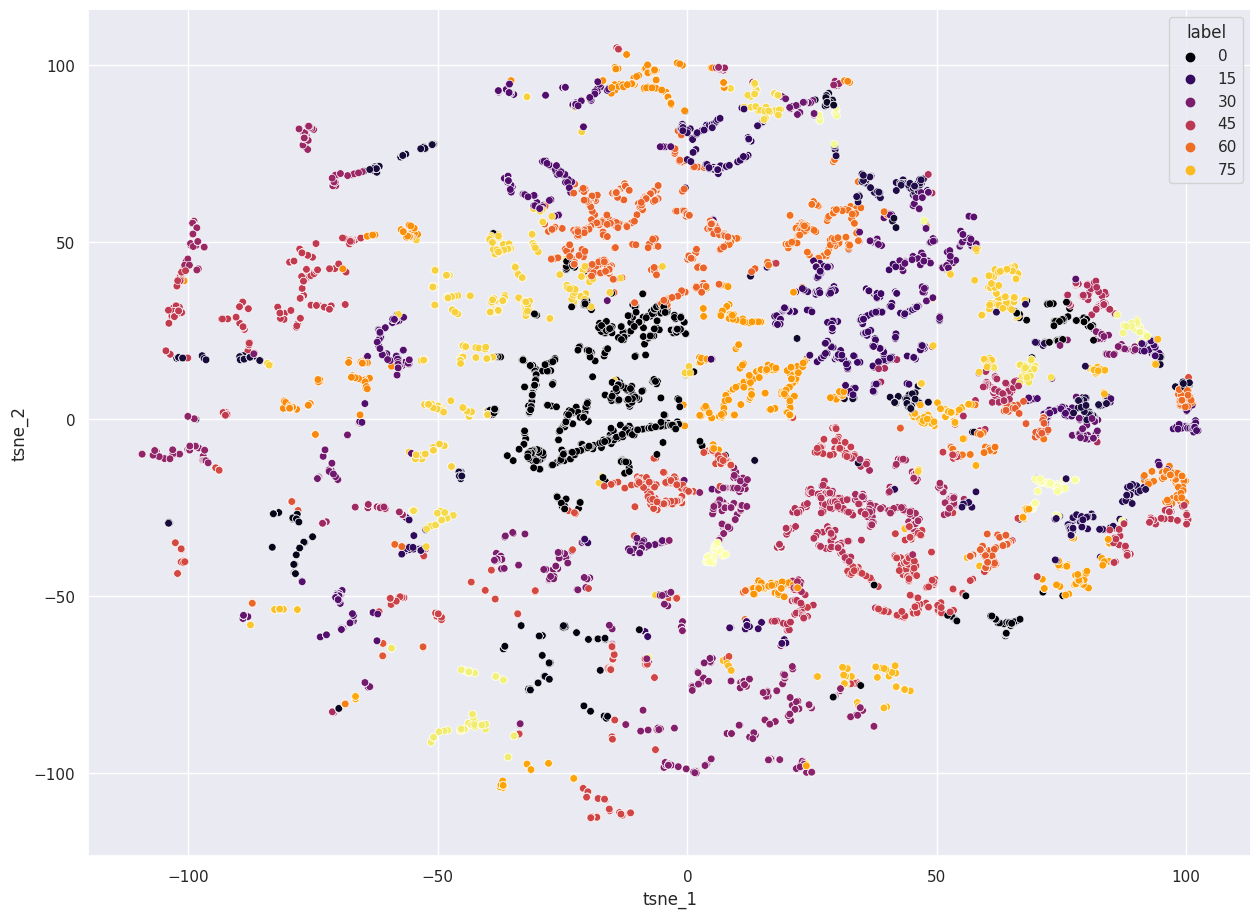

In [204]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': kmeans_labels_emb})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=30,palette='inferno')

In [217]:
# Extract kmeans_lab on node embeddings for each graph

last_idx = 0
kmeans_lab_all=[]

for g in list_graphs:
    
    size_g = nx.number_of_nodes(g)

    kmean_labels = kmeans_labels_emb[last_idx : last_idx + size_g]  # extract graph wise labels
    
    last_idx += size_g
    
    dict_kmeans_lab = dict(enumerate(kmean_labels))  # Convert to dictionary
    
    nx.set_node_attributes(g, dict_kmeans_lab, 'kmeans_lab_emb')  # Add to graph

In [237]:
list_graphs[119].nodes.data()[]

{'vertex_index': 126828,
 'sphere_3dcoords': array([59.14538193, 80.60813904,  2.03748751]),
 'sphere_coords': [0.9377833604812622, 1.5504200458526611],
 'basin_label': 266.0,
 'basin_area': 318.4026,
 'depth': -0.7702932,
 'basin_thickness': 2.4639322757720947,
 'ico100_7_vertex_index': 11889,
 'label_neuroimage': 20,
 'label_media': -2,
 'sphere_3dcoords_noreg': array([56.789288  , 82.30982   ,  0.26568627], dtype=float32),
 'ico100_7_vertex_index_noreg': 11681,
 'is_dummy': False,
 'labelling_mALS': -1.0,
 'labelling_kerGM': 0.5231860053967116,
 'labelling_mSync': 0.5231860053967116,
 'kmeans_lab_emb': 2}

# tsne on graph emb

In [32]:
# gender label for each graph

all_graph_emb = []
last_idx = 0

for g in list_graphs:
    
    size_g = nx.number_of_nodes(g)

    graph_emb = np.mean(out_emb[last_idx : last_idx + size_g],axis=0)
    
    last_idx += size_g
    
    all_graph_emb.append(graph_emb)
    
all_graph_emb = np.array(all_graph_emb)

In [33]:
from sklearn.manifold import TSNE
import pandas as pd

tsne_graph = tsne.fit_transform(g_emb)
tsne_graph.shape

(137, 2)

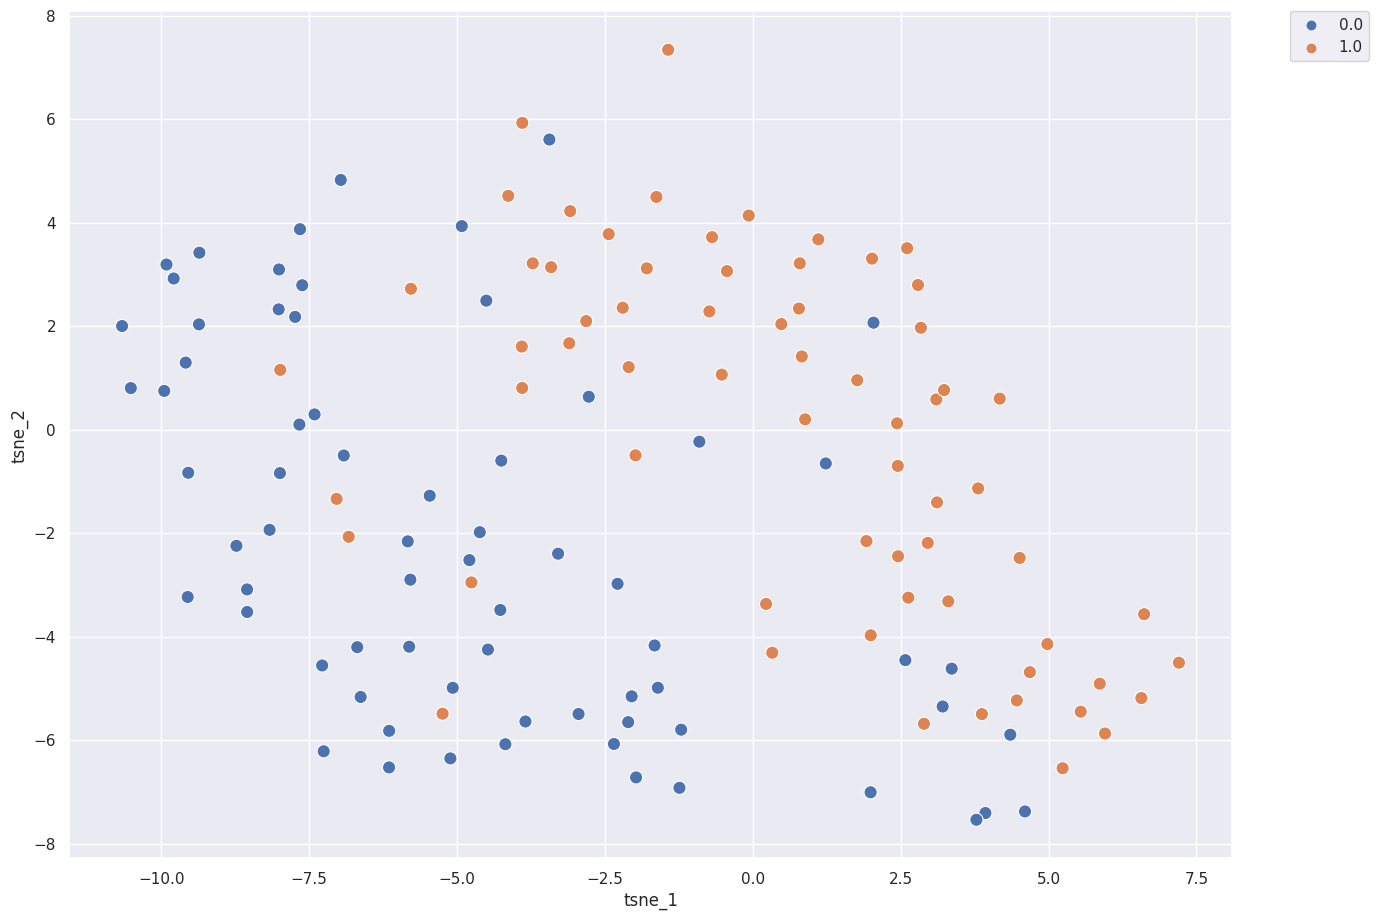

In [34]:
#subj_labels_lst = np.arange(0,137,1)
graph_labels_lst = [lab[0] for lab in graph_labels]
tsne_graph_df = pd.DataFrame({'tsne_1': tsne_graph[:,0], 'tsne_2': tsne_graph[:,1], 'label':graph_labels_lst})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_graph_df, ax=ax,s=90)
lim = (tsne_graph_df.min()-5, tsne_graph_df.max()+5)
#ax.set_xlim(lim)
#ax.set_ylim(lim)
#ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

# node emb by subject

In [35]:
# # sub label for each graph
# sub_labels = []
# for i,g in enumerate(list_graphs):
#     size_g = nx.number_of_nodes(g)
#     sub_labels.extend([i] * size_g)

In [36]:
# sns.set(rc={'figure.figsize':(15,11)})
# #sns.set(rc={'axes.facecolor':'#DCE8F4'})

# tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': sub_labels})
# fig, ax = plt.subplots(1)
# sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=70)
# lim = (tsne_result.min()-5, tsne_result.max()+5)
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# #ax.set_aspect('equal')
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


# Logistic regression on graph embeddings

In [37]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [38]:
clf = LogisticRegression(random_state=0).fit(g_emb[:70], graph_labels_lst[:70])
clf.score(g_emb[:70], graph_labels_lst[:70])

0.9428571428571428

In [39]:
clf.score(g_emb[70:], graph_labels_lst[70:])  #test score

0.7910447761194029

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [41]:
clf_svm = SVC(gamma='auto',kernel='rbf')

In [42]:
clf_svm.fit(g_emb[:70], graph_labels_lst[:70])
clf_svm.score(g_emb[:70], graph_labels_lst[:70])

1.0

In [43]:
clf_svm.score(g_emb[70:], graph_labels_lst[70:])

0.8208955223880597

In [44]:
clf_rf = RandomForestClassifier(max_depth = 4,random_state=0)
clf_rf.fit(g_emb[:70], graph_labels_lst[:70])

RandomForestClassifier(max_depth=4, random_state=0)

In [45]:
clf_rf.score(g_emb[:70], graph_labels_lst[:70])

1.0

In [46]:
clf_rf.score(g_emb[70:], graph_labels_lst[70:])  #test score

0.8059701492537313

# Logistic regression on concat features

In [47]:
np.mean(sulcal_dataset[0].x.detach().numpy(),axis=0)

array([-3.6242810e-01, -9.0095884e-01, -7.9297695e+00,  8.6131146e+02,
        2.6794515e+00, -8.9027262e-01], dtype=float32)

In [48]:
avg_feature = []

for d in sulcal_dataset:
    avg_feature.append(np.mean(d.x.detach().numpy(),axis=0))
    
avg_feature = np.array(avg_feature)

In [49]:
clf_concat = LogisticRegression(random_state=0)
clf_concat.fit(avg_feature[:70], graph_labels_lst[:70])

LogisticRegression(random_state=0)

In [50]:
clf_concat.score(avg_feature[:70], graph_labels_lst[:70])

0.6285714285714286

In [51]:
clf_concat.score(avg_feature[70:], graph_labels_lst[70:])  #test score

0.6417910447761194

In [52]:
clf_concat_svm = SVC(gamma='auto',kernel='linear')
clf_concat_svm.fit(avg_feature[:70], graph_labels_lst[:70])

SVC(gamma='auto', kernel='linear')

In [53]:
clf_concat_svm.score(avg_feature[:70], graph_labels_lst[:70])

0.6714285714285714

In [54]:
clf_concat_svm.score(avg_feature[70:], graph_labels_lst[70:]) #test score

0.7014925373134329

In [55]:
clf_concat_rf = RandomForestClassifier(max_depth = 1,random_state=0)
clf_concat_rf.fit(avg_feature[:70], graph_labels_lst[:70])

RandomForestClassifier(max_depth=1, random_state=0)

In [56]:
clf_concat_rf.score(avg_feature[:70], graph_labels_lst[:70])

0.6857142857142857

In [57]:
clf_concat_rf.score(avg_feature[70:], graph_labels_lst[70:])  #test score

0.7611940298507462

In [58]:
# #3D Plot

# import plotly.express as px

# df_coord = pd.DataFrame({'x': x, 'y':y, 'z':z, 'label': pit_labels})

# fig = px.scatter_3d(df_coord, x = 'x',y = 'y',z = 'z',color='label')

# fig.update_traces(marker={'size': 2})


# fig.show()

# By brain size

In [146]:
from sklearn import preprocessing as pre

all_brain_size = []
all_brain_size_norm = []

for g in list_graphs:
    brain_size = list(nx.get_node_attributes(g,'basin_area'))
    all_brain_size.append(np.sum(brain_size))

x  = np.array(all_brain_size)
x = x.reshape(-1, 1)

all_brain_size_norm = list(pre.MinMaxScaler().fit_transform(x).reshape(len(x)))
    

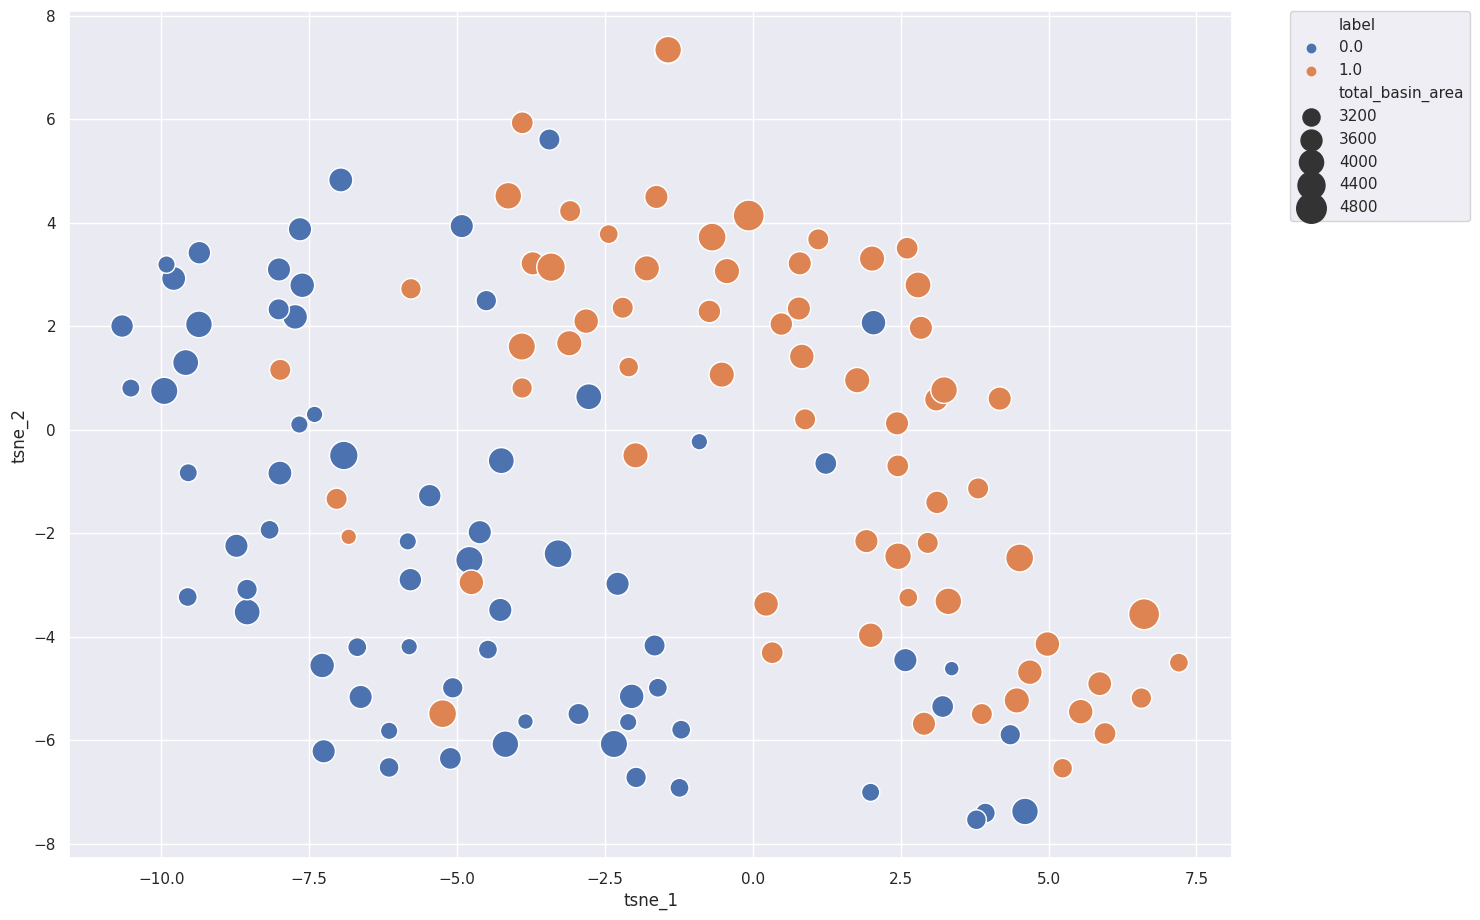

In [147]:


tsne_graph_df = pd.DataFrame({'tsne_1': tsne_graph[:,0], 'tsne_2': tsne_graph[:,1], 'label':graph_labels_lst,'total_basin_area':all_brain_size})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label',sizes=(100, 500), data=tsne_graph_df, ax=ax,size='total_basin_area')
#lim = (tsne_graph_df.min()-5, tsne_graph_df.max()+5)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [61]:
unique, counts = np.unique(np.array(gender_corresp[:70])[:,2], return_counts=True)
dict(zip(unique, counts))

{'F': 35, 'M': 35}

# Predict brain size

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [63]:
reg = SVR(kernel='rbf')
reg.fit(g_emb[:70],all_brain_size_norm[:70])

SVR()

In [64]:
reg.score(g_emb[:70],all_brain_size_norm[:70])

0.5442911435553955

In [65]:
reg.predict(g_emb[71:80])

array([0.30320009, 0.44706961, 0.40745513, 0.52780384, 0.44074708,
       0.25189234, 0.4972683 , 0.54221454, 0.5912968 ])

# Pits gender distribution 

In [80]:
gender_corresp = np.array(gender_corresp)
unique, counts = np.unique(gender_corresp[:,2], return_counts=True)
dict(zip(unique, counts))

{'F': 69, 'M': 68}

In [94]:
corr_M_index = []
corr_F_index = []

for i in range(len(gender_corresp)):
    if gender_corresp[i,2] == 'M':
        corr_M_index.append(i)
    else:
        corr_F_index.append(i)
        
corr_M_index = np.array(corr_M_index)
corr_F_index = np.array(corr_F_index)

In [99]:
num_nodes_M = []
num_nodes_F = []

for k in range(len(list_graphs)):
    if k in corr_M_index:
        num_nodes_M.append(nx.number_of_nodes(list_graphs[k]))
    else:
        num_nodes_F.append(nx.number_of_nodes(list_graphs[k]))

/home/rohit/anaconda3/envs/Slam_python_3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/rohit/anaconda3/envs/Slam_python_3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

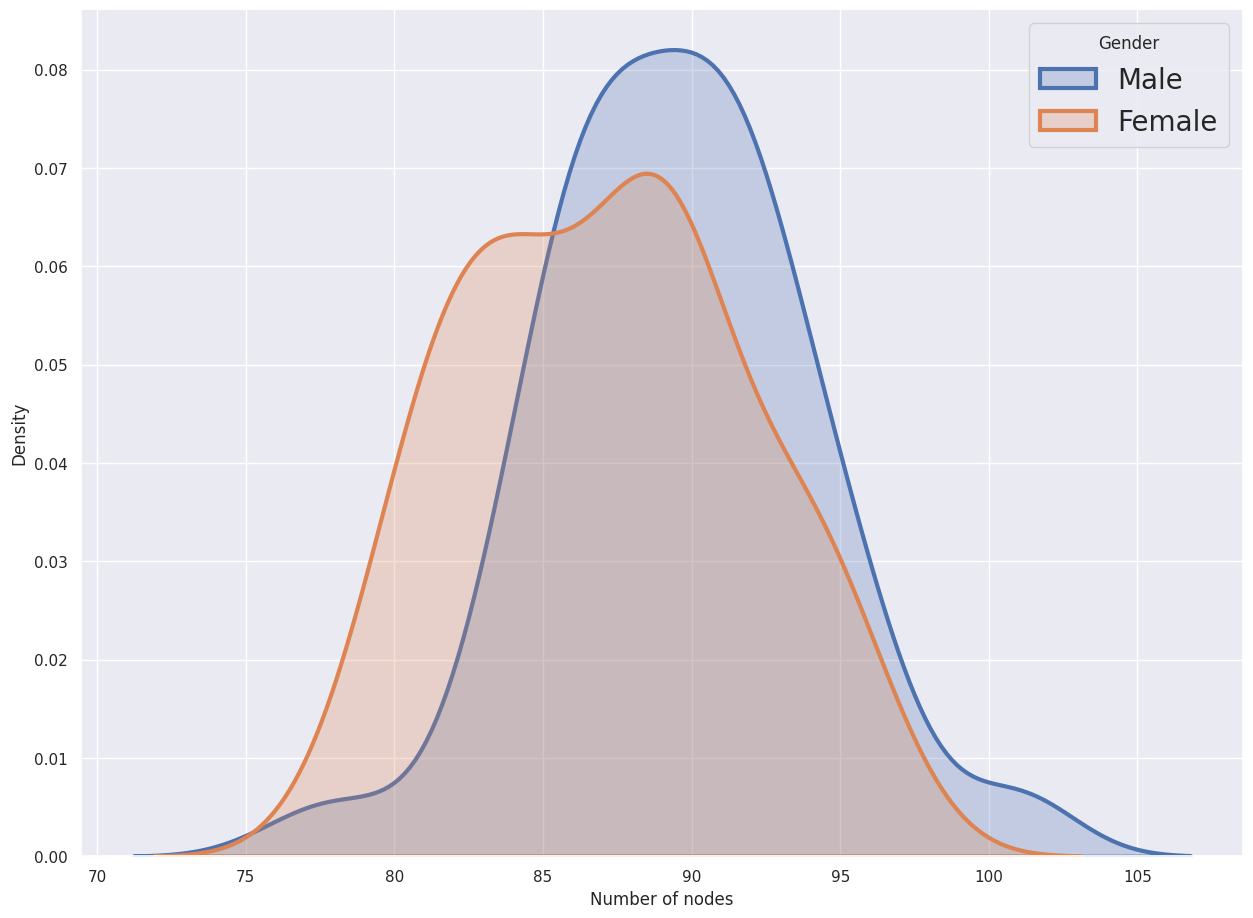

In [148]:
sns.distplot(num_nodes_M, hist = False, kde = True,
         kde_kws = {'shade': True,'linewidth': 3}, label='Male')

sns.distplot(num_nodes_F, hist = False, kde = True,
         kde_kws = {'shade': True,'linewidth': 3}, label='Female')

plt.legend(prop={'size': 20}, title = 'Gender')
plt.title('')
plt.xlabel('Number of nodes')
plt.ylabel('Density')

### Brain size vs number of pits

In [149]:
sizes =  [nx.number_of_nodes(g) for g in list_graphs]

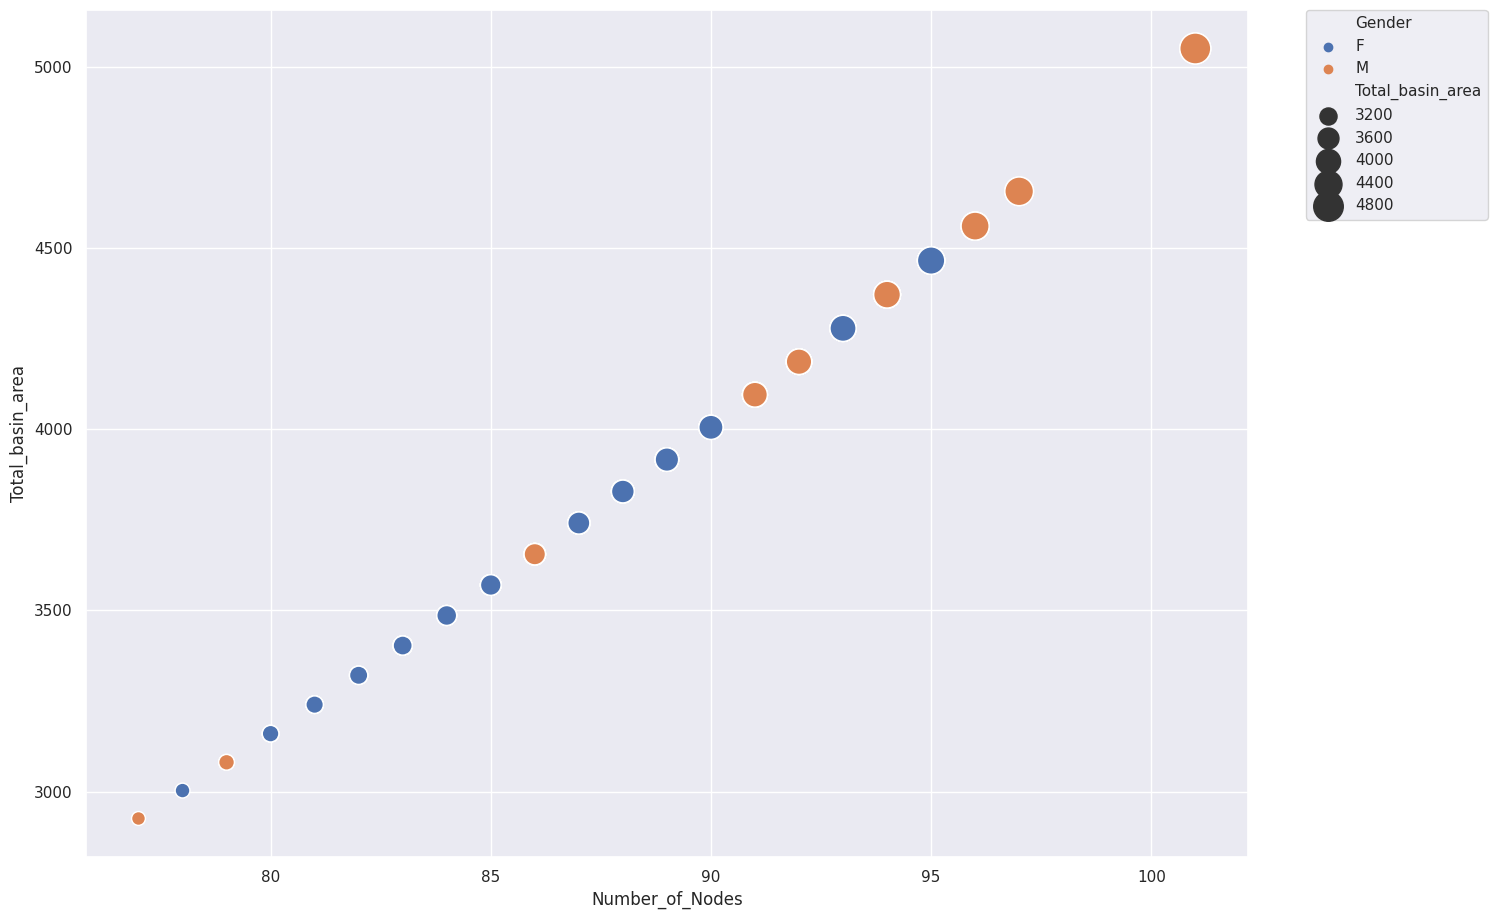

In [161]:
size_gender_df = pd.DataFrame({'Number_of_Nodes': sizes, 'Total_basin_area': all_brain_size, 'Gender':gender_corresp[:,2]})
fig, ax = plt.subplots(1)
sns.scatterplot(x='Number_of_Nodes', y='Total_basin_area', hue='Gender',sizes=(100, 500), data=size_gender_df, ax=ax,size='Total_basin_area')
#sns.scatterplot(x='Number_of_Nodes', y='Total_basin_area', data=size_gender_df, ax=ax,s=30)
# lim = (np.array(sizes).min()-5, np.array(sizes).max()+5)
# ax.set_xlim(lim)
# ax.set_ylim(lim)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)